Here, ANN model is trained on mfcc features calculated using librosa library.

- Following are necessary imports:

In [1]:
# !pip install librosa
# !pip install tqdm
# !python -m pip install livelossplot
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
import os, pathlib, sys
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# from sklearn.metrics import multilabel_confusion_matrix
from IPython import display
from livelossplot import PlotLossesKeras

### Place your dataset in the dataset directory in the following format:

- Copy the dataset from data directory
- data contains data that is of 2/3/5 seconds interval. Choose the dataset of particular interval of interest.
- E.g. if you want to train the model on 2 seconds interval data, copy directories from 'data_2_sec' and place it in dataset folder in following format:

dataset

    |-IVR
        |-ivr.wav
        |-ivr1.wav
        |-ivr2.wav
        |.........

    |-Music
        |-music.wav
        |-music1.wav
        |-music2.wav
        |.........

    |-Speech
        |-speech.wav
        |-speech2.wav
        |-speech3.wav
        |.........

### Feature extraction

#### file names and their labels

- in the first iteration we iterate through directories in the dataset folder and get the labels
- in the second iteration we get the file name and append it in one list
- the other list contains label for that file
- a dataframe is created, both lists are passed to it and then saved

In [ ]:
file_path=os.path.join(os.getcwd(),'dataset/')

lst1 = []
lst2 = []
for path, subdir, file in os.walk(file_path):
    for label in subdir:
        for path, subdir, file in os.walk(os.path.join(file_path,label)):
            for name in file:
                lst1.append(name)
                lst2.append(label)
df = pd.DataFrame(zip(lst1, lst2), columns = ['file_name', 'label'])
print(df)

In [4]:
df.to_csv('file_labels_3.csv', encoding='utf-8', index=False)

#### mfcc feature extraction

- the dataframe created in the previous step contains file path for each file in the directory and label respectively

In [ ]:
audio_dataset_path=os.path.join(os.getcwd(), 'dataset')
print(audio_dataset_path)

- this function accepts the filepath in the argument and calculates mfcc for the audio, scales it and returns it

In [6]:
 def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, sr=8000, res_type='kaiser_fast')
    print(sample_rate)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

- the dataframe has filepath for the audio. it iterates over rows and the calculated mfcc features along with labels are appended in the extracted_features list

In [ ]:
extracted_features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), str(row['label'])+'\\'+str(row['file_name']))
    final_class_labels=row["label"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

- the list is then converted into dataframe

In [ ]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['features','class'])
extracted_features_df.head()

In [9]:
extracted_features_df.to_csv('extracted_features.csv', encoding='utf-8', index=False)

- the dataframe columns are then converted to numpy array

In [11]:
X=np.array(extracted_features_df['features'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

In [ ]:
y.shape

- label encoding, to encode the labels

In [15]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

- train test split the dataset in 70:30 ratio

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30, shuffle=True, random_state=0)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

### Model Creation & Training

In [153]:
num_labels=y.shape[1]

- sequential model is created with adam optimizer and categorical cross entropy as there are more than 2 classes

In [ ]:
model=Sequential()

model.add(Dense(100,input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

- model is trained using 100 epochs, batch size 32, early stopping with patience of 10

In [ ]:
num_epochs = 100
num_batch_size = 32
cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
checkpointer = ModelCheckpoint(filepath='ann_mfcc.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

hist=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_test, y_test), callbacks=[PlotLossesKeras(), checkpointer, cb], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

- after training, loss, validation loss, accuracy, validation accuracy are plotted

In [ ]:
plt.figure(0)
plt.plot(hist.history['loss'],'g', label="Loss")
plt.plot(hist.history['val_loss'],'b',label="Validation Loss")
plt.plot(hist.history['accuracy'],'r', label="Accuracy")
plt.plot(hist.history['val_accuracy'],'black', label="Validation Accuracy")
plt.legend()
plt.show()

### Model Evaluation

- test accuracy is calculated

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

- model predicts X_test set for evaluation

In [ ]:
predict_x=model.predict(X_test)
y_pred=np.argmax(predict_x,axis=1)
y_pred.shape

In [ ]:
y_test_arg=np.argmax(y_test,axis=1)
y_test_arg.shape

In [46]:
prediction_class = labelencoder.inverse_transform(y_pred)

- calculate accuracy, precision, recall, F1 score

In [ ]:
accuracy = accuracy_score(y_test_arg, y_pred)
precision = precision_score(y_test_arg, y_pred, average='weighted')
recall = recall_score(y_test_arg, y_pred, average='weighted')
f1 = f1_score(y_test_arg, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

#### confusion matrix

In [ ]:
# FROM GIT

# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# sns.set()

# y_predicted = model.predict(test_features)
# mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
# class_labels = ['background', 'chainsaw', 'engine', 'storm']

# sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
#             xticklabels=class_labels,
#             yticklabels=class_labels)

# plt.xlabel('Predicted label')
# plt.ylabel('Actual label')

- plot confusion matrix

In [ ]:
cm = confusion_matrix(y_test_arg, y_pred)
print('Confusion matrix:\n', cm)

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

ht=sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ht.set_xticklabels(['Music', 'Speech', 'Synthetic Voice'])
ht.set_yticklabels(['Music', 'Speech', 'Synthetic Voice'])

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
# cm_display.plot()
# plt.show()

#### ROC AUC curve

In [ ]:
y_proba = model.predict(X_test)
y_proba.shape

In [ ]:
y_test.shape

In [ ]:
fpr_list = []
tpr_list = []
threshold_list = []
roc_auc_list = []

for i in range(3):
    false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(y_test[:, i], y_proba[:, i])
    plt.plot(false_positive_rate, true_positive_rate, label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

    plt.figure(figsize=(10, 8), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'g')
    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

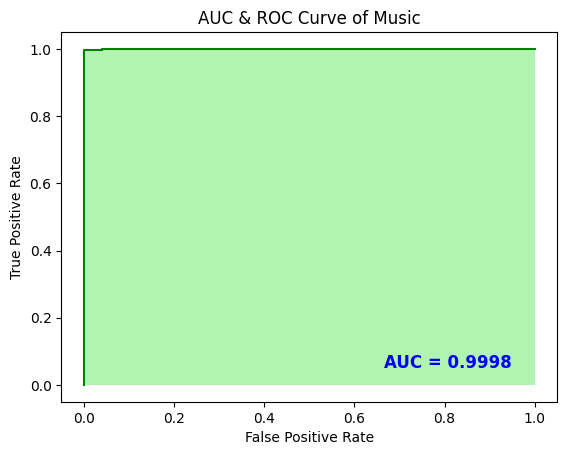

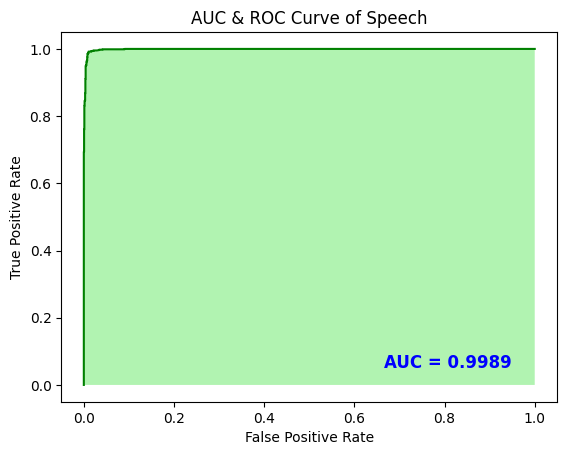

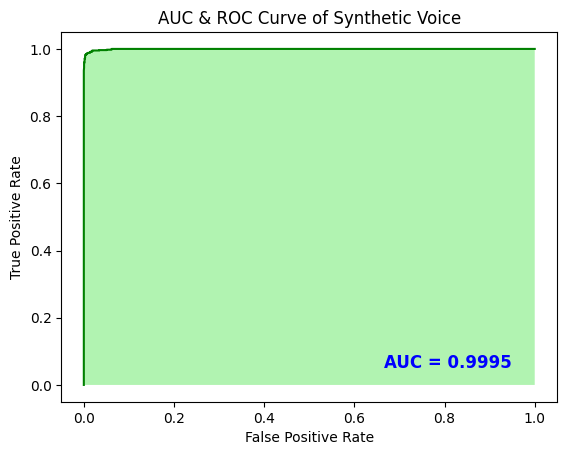

In [132]:
fpr_list = []
tpr_list = []
threshold_list = []
roc_auc_list = []
lab=['Music', 'Speech', 'Synthetic Voice']

for i in range(3):
    fpr, tpr, threshold = metrics.roc_curve(y_test[:, i], y_proba[:, i])
    roc_auc = metrics.auc(fpr, tpr)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    threshold_list.append(threshold)
    roc_auc_list.append(roc_auc)
    
for j in range(len(fpr_list)):
    false_positive_rate, true_positive_rate, threshold = fpr_list[j], tpr_list[j], threshold_list[j]
    plt.title("AUC & ROC Curve of " + lab[j])
    plt.plot(false_positive_rate, true_positive_rate, 'g')
    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % roc_auc_list[j], ha='right', fontsize=12, weight='bold', color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [ ]:
auc = roc_auc_score(y_test_cat, y_proba, multi_class='ovr', average='weighted')
print('ROC AUC score:', auc)

### classification report

In [135]:
cr=classification_report(y_test_arg, y_pred, target_names=['Music', 'Speech', 'Synthetic Voice'], output_dict=True)

,Music,Speech,Synthetic Voice,accuracy,macro avg,weighted avg
precision,0.995449,0.984018,0.988304,0.989272,0.989257,0.989269
recall,0.996583,0.984018,0.987150,0.989272,0.989250,0.989272
f1-score,0.996016,0.984018,0.987726,0.989272,0.989254,0.989270
support,878.000000,876.000000,856.000000,0.989272,2610.000000,2610.000000


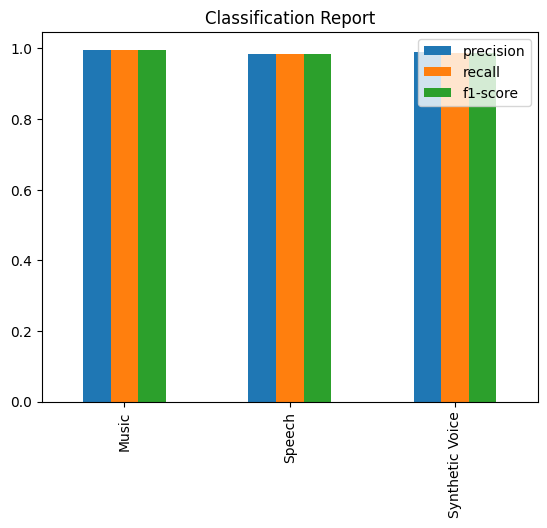

In [137]:
display.display(pd.DataFrame(cr))
df = pd.DataFrame(cr)
df2 = df.rename({'0': 'Music', '1': 'Speech', '2': 'Synthetic Voice'}, axis=1)
df2.iloc[:3, :3].T.plot(kind='bar')
plt.title('Classification Report')
plt.show()

### Testing Some Test Audio Data

Steps
- Preprocess the new audio data
- predict the classes
- Invere transform your Predicted Label

In [5]:
ac_model = load_model('ann_mfcc_3_classes.hdf5')

#### test on files in test folder

In [11]:
y = ['Music','Speech', 'Synthetic Voice']
labelencoder=LabelEncoder()
labelencoder.fit(y)

LabelEncoder()

#### test on single file

- load audio file in librosa
- calculate and scale mfcc
- trained model predicts the features

In [ ]:
filename=r'C:\Users\seema1\Desktop\audio-classification\audio_files\test\speech6.wav'
audio, sample_rate = librosa.load(filename, sr=8000, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)

predicted_label=ac_model.predict(mfccs_scaled_features)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x) 
print((prediction_class)) #np.array

In [ ]:
a=np.array_str(classes_x)
print(len(a))